In [9]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
retail_df = pd.read_excel(io='C:/Users/youdahyun/notebook/Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [15]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [16]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [21]:
retail_df['Country'].value_counts()[:5]

Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: count, dtype: int64

In [22]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


In [26]:
retail_df['sale_amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [29]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

In [34]:
aggregations = {
    'InvoiceDate' : 'max',
    'InvoiceNo' : 'count',
    'sale_amount' : 'sum'}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
cust_df = cust_df.rename(columns = { 'InvoiceDate' : 'Recency',
                                    'InvoiceNo' : 'Frequency',
                                    'sale_amount' : 'Monetary'}
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [50]:
import datetime as dt
cust_df['Recency'] = pd.to_datetime(cust_df['Recency'])
cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days+1)
print('cust_df 로우와 칼럼 건수는 ',cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는  (3920, 5)


,CustomerID,Recency,Frequency,Monetary,cluster_label
0,12346,15318,1,77183.60,0
1,12747,15318,103,4196.01,1
2,12748,15318,4595,33719.73,0


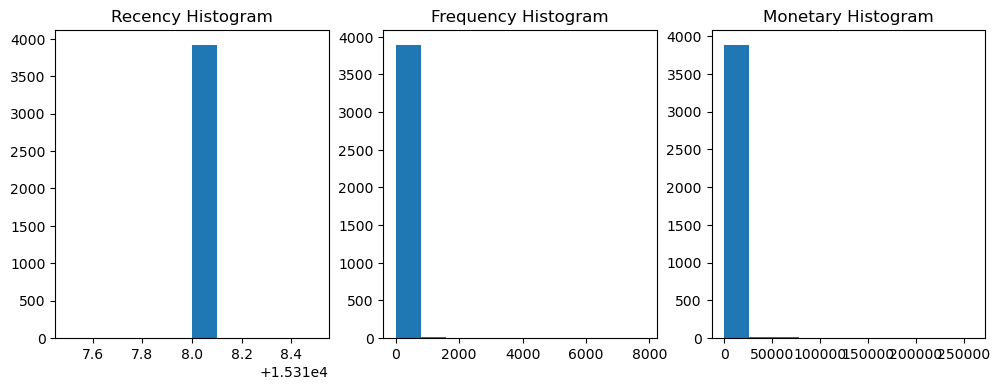

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])
ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])
ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])
plt.show()

In [52]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.0,3920.000000,3920.000000
mean,15318.0,90.388010,1864.385601
std,0.0,217.808385,7482.817477
min,15318.0,1.000000,3.750000
25%,15318.0,17.000000,300.280000
50%,15318.0,41.000000,652.280000
75%,15318.0,99.250000,1576.585000
max,15318.0,7847.000000,259657.300000


In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.952


In [56]:
# visyalize_silhouette([2,3,4,5], X_features_scaled)
# visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
labels = kmeans.fit_predict(X_features_scaled)
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.406
